In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook
from IPython.display import HTML
import time
import datetime
import json

#Import usual things required for graph nets
import numpy as np
import pandas as pd
import networkx as nx
import sonnet as snt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import sys

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Polygon

import seaborn as sns
from sklearn.model_selection import train_test_split

#Import graph nets
from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets import utils_np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#Set seed
SEED = 4038

np.random.seed(SEED)
rand = np.random.RandomState(SEED)
tf.random.set_seed(SEED)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Num GPUs Available:  1


In [2]:
#Path to the scripts shared troughout phases
parent_path=os.path.abspath('..\\..')
path_common =  '\\'.join(parent_path.split('\\')[:-1]) 

#Check if path exists
path_common_scripts = os.path.join(path_common,'Common','Scripts')
if(not os.path.exists(path_common_scripts)):
    print('The path: '+ path_common_scripts+' is not found!')
path_common = os.path.join(path_common,'Common')
#Check if path exists
if(not os.path.exists(path_common)):
    print('The path: '+ path_common+' is not found!')



#Add shared scripts to our current paths for importing
sys.path.insert(0, path_common_scripts)

#Retrieve test specification document
test_spec_json = os.path.join(path_common,'hyper_parameters.json')
#Check if file exists
if(not os.path.exists(test_spec_json)):
    print('The file: '+ test_spec_json+' is not found!')
with open(test_spec_json) as f:
    test_spec = json.load(f)
    
params = test_spec['parameters']

model_params = params['model_parameters']

experiment_params = params['experiment_parameters']

#Save experiment begin date
current_time = datetime.datetime.now()
print("Current_date: "+str(current_time))
current_time = "".join(current_time.strftime("%x").split('/'))

NUM_TRAINING_ITERATIONS = experiment_params['number_of_training_iterations']
LOSS_TYPE = experiment_params['loss_type']
#BATCH_SIZE_TR = experiment_params['training_batch_size']
#BATCH_SIZE_TE = experiment_params['testing_batch_size']
#BATCH_SIZE_GE = experiment_params['generalisation_batch_size']
NUM_PROCESSING_STEPS_TR = experiment_params['number_of_processing_steps_tr']
NUM_PROCESSING_STEPS_TE = experiment_params['number_of_processing_steps_te']
NUM_PROCESSING_STEPS_GE = experiment_params['number_of_processing_steps_ge']
#ROLLOUT_TIMESTEPS = experiment_params['rollout_timesteps']
#ROLLOUT_TIMESTEPS_VIS = experiment_params['rollout_timesteps_vis']

FUL_LATENT_SIZE = model_params['ful_block_latent_size']
FUL_LAYER_NUMBER = model_params['ful_block_number_of_layers']
IND_LATENT_SIZE = model_params['ind_block_latent_size']
IND_LAYER_NUMBER = model_params['ind_block_number_of_layers']

Current_date: 2021-04-27 01:27:10.698797


In [3]:
# Import model
import GNNModels_tf2 as models
# Import training plot
from TrainingPlot import training_plot, training_plot_log_scale
# Import rollout plot
from RolloutPlot import rollout_plot, rollout_plot_log_scale
# Import functions for creating graph
from Graph_creator_functions import rigid_graph_from_pos_all, rigid_graph_from_pos_closest
# Import data loader module
from PushDatasetLoad import load_dataset, collect_trajectory_indeces, create_train_valid_test, collect_states, remove_effector, outlier_remover, dataset_formating
# Import Dataset Feeder function
from PushDatasetFeed import DataFeeder
# Import simulation functions
from PushDatasetSimulator import PushDatasetSimulator
# Import function for experiments
from LossFunctions import velocity_loss_single_step, make_all_runnable_in_session, rollout_loss_mean_velocity, rollout_loss_sum_velocity, rollout_loss_max_velocity, rollout_error_velocity, rollout_error_position
# Import visualisation functions
from VisualisationFunctions import visualise_trajectory, visualise_groundtruth

## Data loading:
In this section of the code we load the data. Split the trajectories into training, validation and testing sets.

In [4]:
#Path to Datasets
path_dataset = os.path.abspath('..\\..\\..\\..\\..')
path_dataset = os.path.join(path_dataset,'Data')

if(not os.path.exists(path_dataset)):
    print("Data folder does not exist.")
    
# Set paths:
file_1 = os.path.join(path_dataset, "Rect1_Data10ms_1_of_2_flagged.csv")
file_2 = os.path.join(path_dataset, "Rect1_Data10ms_2_of_2_flagged.csv")
# Load dataset
df_set_1, STEP_SIZE = load_dataset(file_1)
df_set_2, STEP_SIZE = load_dataset(file_2)

# Collect trajectory indeces
VEL_ACCS = ['10.0-0.0',
            '100.0-0.0', 
            '150.0-0.0',
            '20.0-0.0',
            '200.0-0.0',
            '300.0-0.0', 
            '400.0-0.0', 
            '50.0-0.0', 
            '500.0-0.0', 
            '75.0-0.0']
trajectory_indeces,df_set_1 = collect_trajectory_indeces(df_set_1, ts = STEP_SIZE, vel_accs = VEL_ACCS)

_, df_set_2 = collect_trajectory_indeces(df_set_2, ts = STEP_SIZE, vel_accs = VEL_ACCS)
# Split indeces so that no trajectory is contained in both train, validation or test datasets
tr_inds, va_inds, te_inds = create_train_valid_test(trajectory_indeces, 0.20)

# Collect trajectories from these 
df_tr_1 = collect_states(tr_inds, df_set_1)
df_tr_2 = collect_states(tr_inds, df_set_2)
df_va_1 = collect_states(va_inds, df_set_1)
df_va_2 = collect_states(va_inds, df_set_2)
df_te_1 = collect_states(te_inds, df_set_1)
df_te_2 = collect_states(te_inds, df_set_2)

# Remove Outliers
STATIONARY_THRESHOLD =  0.0001
df_tr_1, df_tr_2 = outlier_remover(df_tr_1, df_tr_2, STATIONARY_THRESHOLD)
df_va_1, df_va_2 = outlier_remover(df_va_1, df_va_2, STATIONARY_THRESHOLD)
df_te_1, df_te_2 = outlier_remover(df_te_1, df_te_2, STATIONARY_THRESHOLD)

min_roll_tr, max_batch_tr, df_tr_1, df_tr_2 = dataset_formating(df_tr_1,df_tr_2)
min_roll_te, max_batch_te, df_te_1, df_te_2 = dataset_formating(df_te_1,df_te_2)
min_roll_va, max_batch_va, df_va_1, df_va_2 = dataset_formating(df_va_1,df_va_2)

print("Tr","Min rollout step number: ", min_roll_tr, ", Max batch size: ",max_batch_tr)
print("Te","Min rollout step number: ", min_roll_te, ", Max batch size: ",max_batch_te)
print("Va","Min rollout step number: ", min_roll_va, ", Max batch size: ",max_batch_va)

BATCH_SIZE_TR = int(max_batch_tr / 4)
BATCH_SIZE_GE = int(max_batch_va) 
BATCH_SIZE_TE = int(max_batch_te)

ROLLOUT_TIMESTEPS = int(min(min_roll_tr,min_roll_te, min_roll_va)/5)
ROLLOUT_TIMESTEPS_GE = int(min_roll_va)
ROLLOUT_TIMESTEPS_TE = int(min_roll_te)

ROLLOUT_TIMESTEPS = 5

print("Tr","Batch Size: ", BATCH_SIZE_TR, ", Rollout length: ",ROLLOUT_TIMESTEPS)
print("Va","Batch Size: ", BATCH_SIZE_GE, ", Rollout length: ",ROLLOUT_TIMESTEPS_GE)
print("Te","Batch Size: ", BATCH_SIZE_TE, ", Rollout length: ",ROLLOUT_TIMESTEPS_TE)

df_dict = {"tr_1":df_tr_1, 
           "tr_2":df_tr_2, 
           "va_1":df_va_1,
           "va_2":df_va_2,
           "te_1":df_te_1,
           "te_2":df_te_2,}

Tr Min rollout step number:  243.0 , Max batch size:  2354
Te Min rollout step number:  232.0 , Max batch size:  297
Va Min rollout step number:  241.0 , Max batch size:  292
Tr Batch Size:  588 , Rollout length:  5
Va Batch Size:  292 , Rollout length:  241
Te Batch Size:  297 , Rollout length:  232


In [5]:
# Folder description to distinguish between experiment runs
desc = "ntr"+str(NUM_TRAINING_ITERATIONS)
desc = desc +"_d"+str(FUL_LAYER_NUMBER)
desc = desc +"l"+str(FUL_LATENT_SIZE)
desc = desc +"d"+str(IND_LAYER_NUMBER)
desc = desc +"l"+str(IND_LATENT_SIZE)
desc = desc +"_ss"+str(STEP_SIZE).split(".")[1]
desc = desc +"_nb"+str(BATCH_SIZE_TR)
desc = desc +"_nr"+str(ROLLOUT_TIMESTEPS)
desc = desc +"_vs"

#for i in range(len(VEL_ACCS)):
#    v = VEL_ACCS[i].split("-")[0].split(".")[0]
#    if i == len(VEL_ACCS)-1:
#        desc = desc + v
#    else:
#        desc = desc + v + "-"
        
desc = desc +"_lt" +str(LOSS_TYPE)[0]
desc = desc +"_da"+str(current_time)
desc = desc +"_se"+str(SEED)

In [6]:
# Setup folders
base = os.getcwd()
if(not os.path.exists(base)):
    os.makedirs(base)
    
#Path to saved models and trajectories
path_saves = os.path.join(base,desc,'Saves')
if(not os.path.exists(path_saves)):
    os.makedirs(path_saves)
    
#Path to plots
path_plots = os.path.join(base,desc,'Plots')
if(not os.path.exists(path_plots)):
    os.makedirs(path_plots)
    
#Path to animations
path_animations = os.path.join(base,desc,'Animations')
if(not os.path.exists(path_animations)):
    os.makedirs(path_animations)
    
#Save the used parameters as a json file into this folder
with open(os.path.join(path_saves,'specification.json'), 'w') as fp:
    json.dump(test_spec, fp)

# Train

In [7]:
# Create the model.
model = models.EncodeProcessDecode(ind_layer_numbers = IND_LAYER_NUMBER,
                                   ind_latent_unit_size = IND_LATENT_SIZE,
                                   ful_layer_numbers = FUL_LAYER_NUMBER,
                                   ful_latent_unit_size = FUL_LATENT_SIZE,
                                   node_output_size=2,
                                   edge_output_size=2,
                                   global_output_size=1)



LEARNING_RATE = model_params['learning_rate']
optimizer = snt.optimizers.Adam(0.0002)

In [8]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
path_ckpts = os.path.join(path_saves,'tf_ckpts')
manager = tf.train.CheckpointManager(ckpt, path_ckpts, max_to_keep=3)

if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [9]:
def update_step(inputs_tr, targets_tr):
    with tf.GradientTape() as tape:
        outputs_tr = model(inputs_tr, 1)
        # Only Nodes
        outputs_tr_nodes = outputs_tr[0].nodes
        targets_tr_nodes = targets_tr.nodes
        # Loss
        loss_tr = velocity_loss_single_step(targets_tr, outputs_tr[0])
    
    gradients = tape.gradient(loss_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return outputs_tr, loss_tr, gradients

def test_step(inputs, targets):
    outputs = model(inputs, 1)
    # Only Nodes
    output_nodes = outputs[0].nodes
    target_nodes = targets.nodes
    
    # Loss
    loss = velocity_loss_single_step(targets, outputs[0])
    
    return loss


def update_step_rollout(inputs_tr, targets_tr):
    with tf.GradientTape() as tape:
        # Predict trajectory using the model
        pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, inputs_tr, targets_tr)
        # Loss tr
        loss_tr = rollout_loss_mean_velocity(real_trajectory, pred_trajectory)
        
    gradients = tape.gradient(loss_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return 0, loss_tr, gradients

def test_step_rollout(inputs, targets, sim):
    # Predict trajectory using the model
    pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, inputs, targets)
    
    # Loss
    loss = rollout_loss_mean_velocity(real_trajectory, pred_trajectory)
                        
    return loss


## Compiling loss function

In [10]:
# Setup data feeder and simulator

# One step data feeder
feeder = DataFeeder(SEED)
d = feeder.get_data(dfs = df_dict,
                    tr_batch_size = BATCH_SIZE_TR,
                    va_batch_size = BATCH_SIZE_GE,
                    te_batch_size = BATCH_SIZE_TE,
                    graph_creator = rigid_graph_from_pos_all)

# Rollout simulator feeder
sim = PushDatasetSimulator(rollout_steps = ROLLOUT_TIMESTEPS, 
                           step_size = STEP_SIZE)

sim_te = PushDatasetSimulator(rollout_steps = min(ROLLOUT_TIMESTEPS_GE, ROLLOUT_TIMESTEPS_TE), 
                           step_size = STEP_SIZE)
# ------------------------------------------------------------------------

# Get data from feeder
X_tr_step = d["X_tr"]
Y_tr_step = d["Y_tr"]

# Get data from simulator
real, pred, i_np, _ = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
X_tr_roll, Y_tr_roll = sim.convert_trajectories(real, pred)

# ------------------------------------------------------------------------

# Get input signature of one step input
input_signature_step = [
    utils_tf.specs_from_graphs_tuple(X_tr_step),
    utils_tf.specs_from_graphs_tuple(X_tr_step)]

# Get input signature of rollout input
input_signature_rollout = [
    [utils_tf.specs_from_graphs_tuple(X_tr_roll[0])]*ROLLOUT_TIMESTEPS,
    [utils_tf.specs_from_graphs_tuple(Y_tr_roll[0])]*ROLLOUT_TIMESTEPS]

# ------------------------------------------------------------------------

# Compile the update function using the input signature for speedy code
compiled_update_step = tf.function(update_step, input_signature = input_signature_step)
compiled_update_step_rollout = tf.function(update_step_rollout, input_signature = input_signature_rollout)

In [11]:
tf.config.run_functions_eagerly(False)
# Setup logging
last_iteration = 0
logged_iterations = []
losses_step_tr = []
losses_step_va = []
losses_step_te = []

losses_roll_tr = []
losses_roll_va = []
losses_roll_te = []
gradients = []

log_every_iteration = 5

print("# (iteration number) out of max iteration, T (elapsed seconds), "
      "Ltr, "
      "Lte, "
      "Lge")

start_time = time.time()
last_log_time = start_time


best_loss = 1000
 
for iteration in range(last_iteration, NUM_TRAINING_ITERATIONS):
    last_iteration = iteration
    do_logging = (last_iteration % log_every_iteration == 0)
    
    loss_roll_tr = tf.constant([0])
    loss_step_tr = tf.constant([0])
    gradient = tf.constant([0])
    
    if LOSS_TYPE == "rollout":
        # Get training data: Rollout
        real_tr, pred_tr, i_np, _ = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
        X_roll_tr, Y_roll_tr = sim.convert_trajectories(real_tr, pred_tr)

        X_step_tr = X_roll_tr[0]
        Y_step_tr = Y_roll_tr[0]   
        # Training:  One-step
        loss_step_tr = test_step(X_step_tr, Y_step_tr)
        # Do one tick of training    
        outputs_tr, loss_roll_tr, gradient = compiled_update_step_rollout(X_roll_tr, Y_roll_tr)
        
    elif LOSS_TYPE == "step":
        d = feeder.get_data(dfs = df_dict,
                    tr_batch_size = BATCH_SIZE_TR,
                    va_batch_size = BATCH_SIZE_GE,
                    te_batch_size = BATCH_SIZE_TE,
                    graph_creator = rigid_graph_from_pos_all,
                    te_and_va = False)
        
        # Get data from feeder
        X_step_tr = d["X_tr"]
        Y_step_tr = d["Y_tr"]

        # Do one tick of training    
        outputs_tr, loss_step_tr, gradient = compiled_update_step(X_step_tr, Y_step_tr)
        
    else:
        # Get training data: Rollout
        real_tr, pred_tr, i_np, _ = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
        X_roll_tr, Y_roll_tr = sim.convert_trajectories(real_tr, pred_tr)

        X_step_tr = X_roll_tr[0]
        Y_step_tr = Y_roll_tr[0]   
        # Training:  Rollout
        loss_roll_tr = test_step_rollout(X_roll_tr, Y_roll_tr, sim)
        # Do one tick of training    
        outputs_tr, loss_step_tr, gradient = compiled_update_step(X_step_tr, Y_step_tr)
    
    
    ckpt.step.assign_add(1)
    # Don't log at every iteration
    if do_logging:
        # Get validation and test data: Rollout
        real_va, pred_va, _ , _ = sim.get_trajectories(df_va_1, df_va_2, BATCH_SIZE_GE, rigid_graph_from_pos_all)
        X_roll_va, Y_roll_va = sim.convert_trajectories(real_va, pred_va)
        real_te, pred_te, _ , _ = sim.get_trajectories(df_te_1, df_te_2, BATCH_SIZE_TE, rigid_graph_from_pos_all)
        X_roll_te, Y_roll_te = sim.convert_trajectories(real_te, pred_te)
        
        # Get validation and test data: One-step
        X_step_va = X_roll_va[0]
        Y_step_va = Y_roll_va[0]
        X_step_te = X_roll_te[0]
        Y_step_te = Y_roll_te[0]      
        
        # Validation and Test: Rollout
        loss_roll_va = test_step_rollout(X_roll_va, Y_roll_va, sim_te)
        loss_roll_te = test_step_rollout(X_roll_te, Y_roll_te, sim_te)
        
        # Validation and Test: One-step
        loss_step_va = test_step(X_step_va, Y_step_va)
        loss_step_te = test_step(X_step_te, Y_step_te)
        
        # Convert losses to normal values
        loss_roll_tr = loss_roll_tr[0].numpy()
        loss_roll_va = loss_roll_va[0].numpy()
        loss_roll_te = loss_roll_te[0].numpy()
        loss_step_tr = loss_step_tr[0].numpy()
        loss_step_va = loss_step_va[0].numpy()
        loss_step_te = loss_step_te[0].numpy()
        
        the_time = time.time()
        elapsed_since_last_log = the_time - last_log_time
        last_log_time = the_time
        
        # Save
        if best_loss > loss_step_va:
            save_path = manager.save()
            print("Saved checkpoint for step {}".format(int(ckpt.step)))
            best_loss = loss_step_va.copy()
        
        # Log data
        elapsed = time.time() - start_time
        losses_roll_tr.append(loss_roll_tr)
        losses_roll_va.append(loss_roll_va)
        losses_roll_te.append(loss_roll_te)
        
        losses_step_tr.append(loss_step_tr)
        losses_step_va.append(loss_step_va)
        losses_step_te.append(loss_step_te)
        
        gradients.append(gradient)
        logged_iterations.append(iteration)
        
        
        print("# {:05d}, Max {:05d}, T {:.1f}, Ltr Step {:.6f}, Lva Step {:.6f}, Lte Step {:.6f}".format(
            iteration, NUM_TRAINING_ITERATIONS, elapsed, loss_step_tr, loss_step_va, loss_step_te))
        print("# {:05d}, Max {:05d}, T {:.1f}, Ltr Roll {:.6f}, Lva Roll {:.6f}, Lte Roll {:.6f}".format(
            iteration, NUM_TRAINING_ITERATIONS, elapsed, loss_roll_tr, loss_roll_va, loss_roll_te))
        print("-----------------------------------------------------------------------------------")
    
tf.config.run_functions_eagerly(True)    

# (iteration number) out of max iteration, T (elapsed seconds), Ltr, Lte, Lge


C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/EncodePr

Saved checkpoint for step 2
# 00000, Max 01000, T 18.5, Ltr Step 1.051983, Lva Step 4.310863, Lte Step 4.105635
# 00000, Max 01000, T 18.5, Ltr Roll 0.000000, Lva Roll 2.584492, Lte Roll 2.612292
-----------------------------------------------------------------------------------
Saved checkpoint for step 7
# 00005, Max 01000, T 30.0, Ltr Step 0.133067, Lva Step 0.115648, Lte Step 0.106582
# 00005, Max 01000, T 30.0, Ltr Roll 0.000000, Lva Roll 0.083753, Lte Roll 0.078871
-----------------------------------------------------------------------------------
Saved checkpoint for step 12
# 00010, Max 01000, T 41.3, Ltr Step 0.025764, Lva Step 0.042878, Lte Step 0.050216
# 00010, Max 01000, T 41.3, Ltr Roll 0.000000, Lva Roll 0.030923, Lte Roll 0.041976
-----------------------------------------------------------------------------------
Saved checkpoint for step 17
# 00015, Max 01000, T 53.4, Ltr Step 0.023662, Lva Step 0.024647, Lte Step 0.028119
# 00015, Max 01000, T 53.4, Ltr Roll 0.000000,

# 00155, Max 01000, T 373.4, Ltr Step 0.001202, Lva Step 0.004664, Lte Step 0.004336
# 00155, Max 01000, T 373.4, Ltr Roll 0.000000, Lva Roll 0.007314, Lte Roll 0.008030
-----------------------------------------------------------------------------------
# 00160, Max 01000, T 386.4, Ltr Step 0.001410, Lva Step 0.004668, Lte Step 0.004089
# 00160, Max 01000, T 386.4, Ltr Roll 0.000000, Lva Roll 0.007903, Lte Roll 0.007374
-----------------------------------------------------------------------------------
# 00165, Max 01000, T 398.3, Ltr Step 0.001326, Lva Step 0.004458, Lte Step 0.003963
# 00165, Max 01000, T 398.3, Ltr Roll 0.000000, Lva Roll 0.007012, Lte Roll 0.008010
-----------------------------------------------------------------------------------
# 00170, Max 01000, T 410.0, Ltr Step 0.001261, Lva Step 0.004996, Lte Step 0.004132
# 00170, Max 01000, T 410.0, Ltr Roll 0.000000, Lva Roll 0.006956, Lte Roll 0.007330
--------------------------------------------------------------------

# 00320, Max 01000, T 760.5, Ltr Step 0.002107, Lva Step 0.003942, Lte Step 0.004148
# 00320, Max 01000, T 760.5, Ltr Roll 0.000000, Lva Roll 0.007568, Lte Roll 0.007880
-----------------------------------------------------------------------------------
Saved checkpoint for step 327
# 00325, Max 01000, T 771.9, Ltr Step 0.001022, Lva Step 0.002597, Lte Step 0.003901
# 00325, Max 01000, T 771.9, Ltr Roll 0.000000, Lva Roll 0.004647, Lte Roll 0.007515
-----------------------------------------------------------------------------------
# 00330, Max 01000, T 782.9, Ltr Step 0.001244, Lva Step 0.004280, Lte Step 0.004414
# 00330, Max 01000, T 782.9, Ltr Roll 0.000000, Lva Roll 0.006054, Lte Roll 0.007607
-----------------------------------------------------------------------------------
# 00335, Max 01000, T 794.0, Ltr Step 0.001210, Lva Step 0.004664, Lte Step 0.004486
# 00335, Max 01000, T 794.0, Ltr Roll 0.000000, Lva Roll 0.006275, Lte Roll 0.007763
--------------------------------------

# 00485, Max 01000, T 1142.5, Ltr Step 0.000910, Lva Step 0.004866, Lte Step 0.003854
# 00485, Max 01000, T 1142.5, Ltr Roll 0.000000, Lva Roll 0.007152, Lte Roll 0.006873
-----------------------------------------------------------------------------------
# 00490, Max 01000, T 1154.0, Ltr Step 0.000780, Lva Step 0.005399, Lte Step 0.004413
# 00490, Max 01000, T 1154.0, Ltr Roll 0.000000, Lva Roll 0.008836, Lte Roll 0.007513
-----------------------------------------------------------------------------------
# 00495, Max 01000, T 1165.4, Ltr Step 0.000924, Lva Step 0.003219, Lte Step 0.005199
# 00495, Max 01000, T 1165.4, Ltr Roll 0.000000, Lva Roll 0.005616, Lte Roll 0.008907
-----------------------------------------------------------------------------------
# 00500, Max 01000, T 1177.1, Ltr Step 0.000838, Lva Step 0.003461, Lte Step 0.004329
# 00500, Max 01000, T 1177.1, Ltr Roll 0.000000, Lva Roll 0.005909, Lte Roll 0.007362
------------------------------------------------------------

# 00650, Max 01000, T 1517.9, Ltr Step 0.001109, Lva Step 0.003659, Lte Step 0.004401
# 00650, Max 01000, T 1517.9, Ltr Roll 0.000000, Lva Roll 0.005448, Lte Roll 0.008078
-----------------------------------------------------------------------------------
# 00655, Max 01000, T 1528.9, Ltr Step 0.001162, Lva Step 0.004445, Lte Step 0.003461
# 00655, Max 01000, T 1528.9, Ltr Roll 0.000000, Lva Roll 0.008385, Lte Roll 0.007328
-----------------------------------------------------------------------------------
# 00660, Max 01000, T 1539.9, Ltr Step 0.000879, Lva Step 0.003539, Lte Step 0.004193
# 00660, Max 01000, T 1539.9, Ltr Roll 0.000000, Lva Roll 0.004860, Lte Roll 0.006550
-----------------------------------------------------------------------------------
# 00665, Max 01000, T 1550.9, Ltr Step 0.001010, Lva Step 0.004429, Lte Step 0.004936
# 00665, Max 01000, T 1550.9, Ltr Roll 0.000000, Lva Roll 0.007070, Lte Roll 0.007167
------------------------------------------------------------

# 00810, Max 01000, T 1879.6, Ltr Step 0.000848, Lva Step 0.004253, Lte Step 0.004908
# 00810, Max 01000, T 1879.6, Ltr Roll 0.000000, Lva Roll 0.005065, Lte Roll 0.008237
-----------------------------------------------------------------------------------
# 00815, Max 01000, T 1890.8, Ltr Step 0.000983, Lva Step 0.003680, Lte Step 0.004522
# 00815, Max 01000, T 1890.8, Ltr Roll 0.000000, Lva Roll 0.005889, Lte Roll 0.008199
-----------------------------------------------------------------------------------
# 00820, Max 01000, T 1902.1, Ltr Step 0.001183, Lva Step 0.003864, Lte Step 0.004846
# 00820, Max 01000, T 1902.1, Ltr Roll 0.000000, Lva Roll 0.005819, Lte Roll 0.008229
-----------------------------------------------------------------------------------
# 00825, Max 01000, T 1913.6, Ltr Step 0.000840, Lva Step 0.003434, Lte Step 0.003812
# 00825, Max 01000, T 1913.6, Ltr Roll 0.000000, Lva Roll 0.004807, Lte Roll 0.005758
------------------------------------------------------------

# 00975, Max 01000, T 2256.3, Ltr Step 0.000975, Lva Step 0.003769, Lte Step 0.003396
# 00975, Max 01000, T 2256.3, Ltr Roll 0.000000, Lva Roll 0.004882, Lte Roll 0.005563
-----------------------------------------------------------------------------------
# 00980, Max 01000, T 2267.3, Ltr Step 0.001235, Lva Step 0.003630, Lte Step 0.004331
# 00980, Max 01000, T 2267.3, Ltr Roll 0.000000, Lva Roll 0.006966, Lte Roll 0.007476
-----------------------------------------------------------------------------------
# 00985, Max 01000, T 2278.6, Ltr Step 0.000820, Lva Step 0.003743, Lte Step 0.004182
# 00985, Max 01000, T 2278.6, Ltr Roll 0.000000, Lva Roll 0.006078, Lte Roll 0.006625
-----------------------------------------------------------------------------------
# 00990, Max 01000, T 2290.2, Ltr Step 0.000992, Lva Step 0.003675, Lte Step 0.003664
# 00990, Max 01000, T 2290.2, Ltr Roll 0.000000, Lva Roll 0.005306, Lte Roll 0.005304
------------------------------------------------------------

## Restore best model

In [12]:
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from C:\Users\vbenc\Projects\Honours\Honours3\Phases\Phase3\Ex-PosVsVel\O-Vel\ntr1000_d2l256d2l256_ss01_nb588_nr5_vs_lts_da042721_se4038\Saves\tf_ckpts\ckpt-22


## Saving losses

In [13]:
def save_data(name, data):
    data = np.array(data)
    if os.path.exists(os.path.join(path_saves, name)):
        print("The file: "+ name + " already exists. Delete it before saving a new trajectory!")
    else:
        if not os.path.exists(os.path.join(path_saves)):
            os.makedirs(os.path.join(path_saves)) 
            
        np.save(os.path.join(path_saves, name), data)

save_data("iterations", logged_iterations)
save_data("losses_step_tr", losses_step_tr)
save_data("losses_step_te", losses_step_te)
save_data("losses_step_va", losses_step_va)
save_data("losses_roll_tr", losses_roll_tr)
save_data("losses_roll_te", losses_roll_te)
save_data("losses_roll_va", losses_roll_va)
save_data("gradients", gradients)


C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


<IPython.core.display.Javascript object>


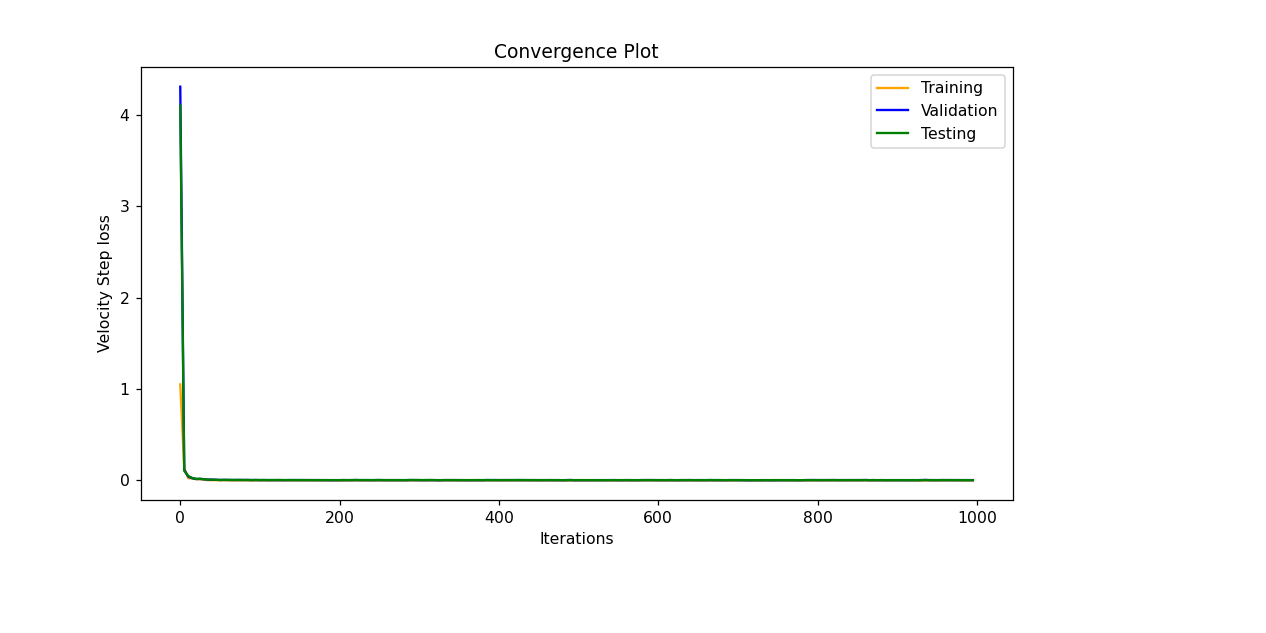

In [14]:
plt.close('all')
fig, ax = training_plot(logged_iterations, losses_step_tr, losses_step_va, losses_step_te, path_plots, loss = "Velocity Step", title = "Convergence Plot")
plt.show()

<IPython.core.display.Javascript object>


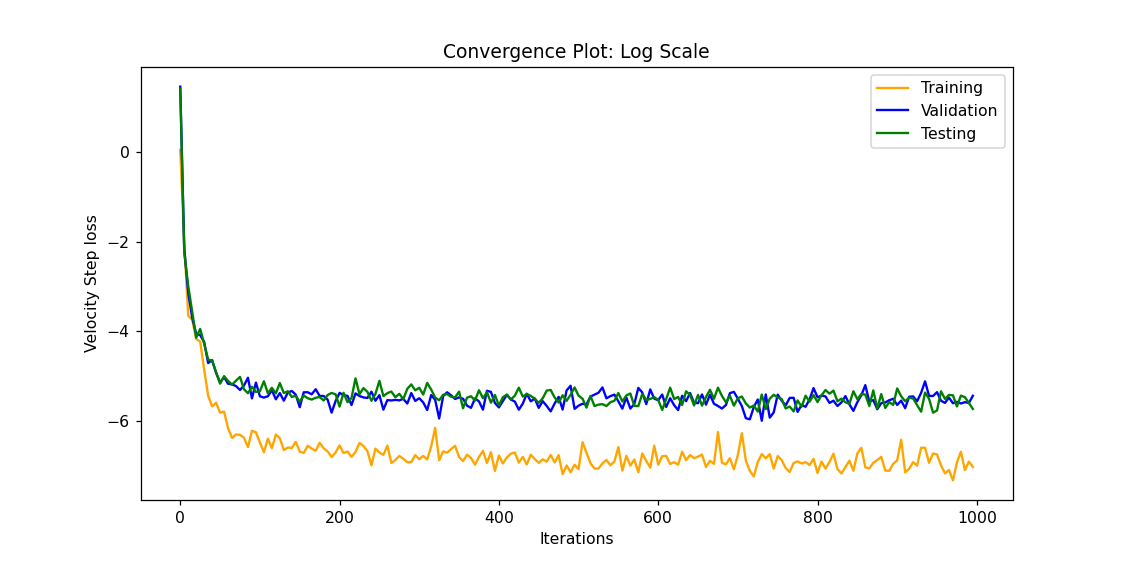

In [15]:
plt.close('all')
fig, ax = training_plot_log_scale(logged_iterations, losses_step_tr, losses_step_va, losses_step_te, path_plots, loss = "Velocity Step", title = "Convergence Plot: Log Scale")
plt.show()

<IPython.core.display.Javascript object>


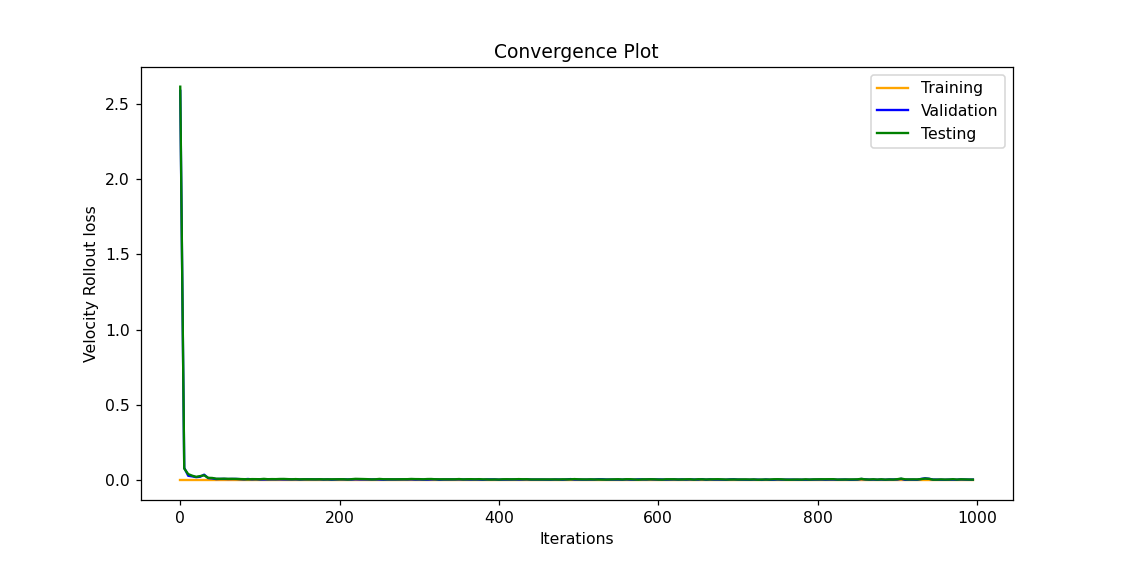

In [16]:
plt.close('all')
fig, ax = training_plot(logged_iterations, losses_roll_tr, losses_roll_va, losses_roll_te, path_plots, loss = "Velocity Rollout", title = "Convergence Plot")
plt.show()

<IPython.core.display.Javascript object>


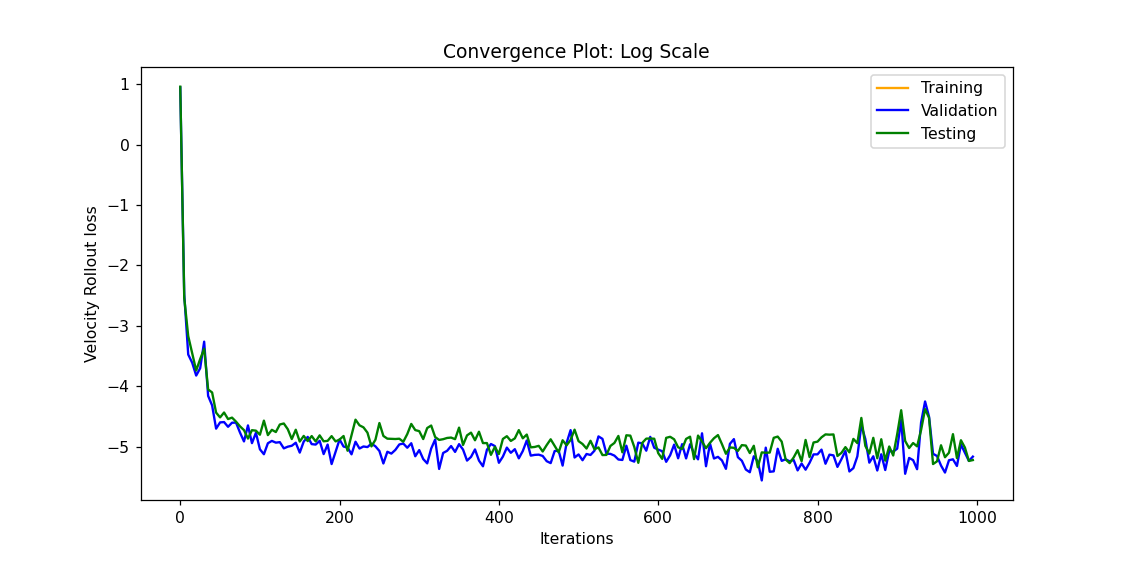

C:\Users\vbenc\Projects\Honours\Honours3\Phases\Common\Scripts\TrainingPlot.py:64: RuntimeWarning: divide by zero encountered in log
  y = np.log(tr_loss)


In [17]:
plt.close('all')
fig, ax = training_plot_log_scale(logged_iterations, losses_roll_tr, losses_roll_va, losses_roll_te, path_plots, loss = "Velocity Rollout", title = "Convergence Plot: Log Scale")
plt.show()

## Evaluation

In [18]:

df = df_te_1.groupby('trajectory')['id'].nunique()
df

trajectory
4.0       50
10.0      50
25.0      28
43.0      49
54.0      53
          ..
3913.0    56
3924.0    67
3944.0    25
3949.0    47
3952.0    11
Name: id, Length: 297, dtype: int64

In [20]:
# Simulator
TRAJ_ID = 3944.0                     

sim = PushDatasetSimulator(rollout_steps = 20, 
                           step_size = STEP_SIZE)

X_g, Y_g, i_np, traj_ids = sim.get_trajectories(df_te_1, df_te_2, 1, rigid_graph_from_pos_all, trajectory_ids=[TRAJ_ID])

# Convert trajectories into graphs
traj_X, traj_Y = sim.convert_trajectories(X_g, Y_g)
# Predict trajectory using the model
pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, traj_X, traj_Y)

<IPython.core.display.Javascript object>


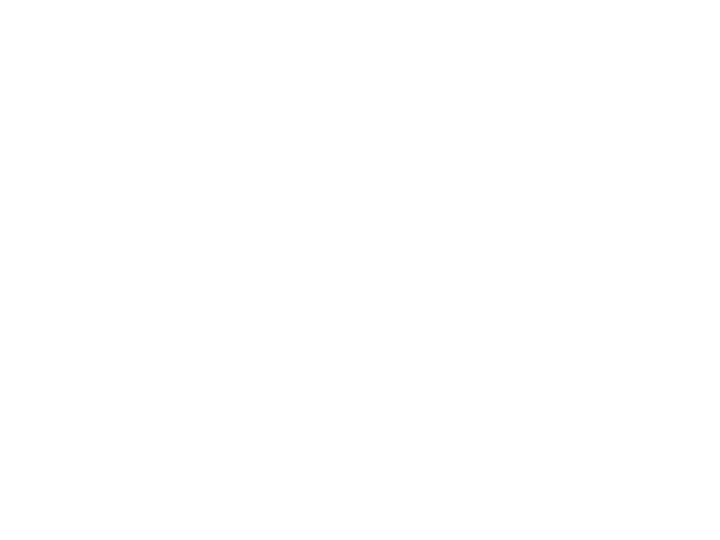

In [21]:
plt.close('all')
fig, ax, anim = visualise_trajectory(pred_trajectory, real_trajectory, TRAJ_ID)
anim.save(os.path.join(path_animations,'visualisation'+str(TRAJ_ID)+'.gif'), writer='imagemagick', fps=60)
plt.close('all')
HTML(anim.to_jshtml())

In [22]:
# Simulator
sim = PushDatasetSimulator(rollout_steps = 50, 
                           step_size = STEP_SIZE)

X_g, Y_g, i_np, _ = sim.get_trajectories(df_te_1, df_te_2, BATCH_SIZE_TE, rigid_graph_from_pos_all)
# Convert trajectories into graphs
traj_X, traj_Y = sim.convert_trajectories(X_g,Y_g)
# Predict trajectory using the model
pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, traj_X, traj_Y)
# Get error in rollout
steps_vel, error_vel = rollout_error_velocity(pred_trajectory, real_trajectory)
error_vel = error_vel + 0.000002

steps_pos, error_pos = rollout_error_position(pred_trajectory, real_trajectory)
error_pos = error_pos + 0.000002

<IPython.core.display.Javascript object>


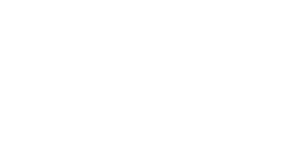

In [23]:
plt.close('all')
fig, ax = rollout_plot(steps_vel, error_vel, path_plots, metric = "Velocity", title = "Rollout Plot")
plt.show()

<IPython.core.display.Javascript object>


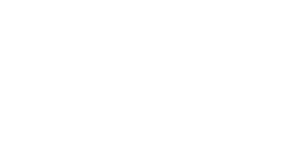

In [24]:
plt.close('all')
fig, ax = rollout_plot_log_scale(steps_vel, error_vel, path_plots, metric = "Velocity", title = "Rollout Plot: Log Scale")
plt.show()

<IPython.core.display.Javascript object>


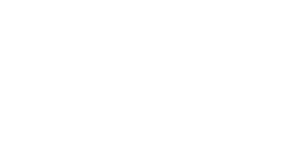

In [25]:
plt.close('all')
fig, ax = rollout_plot(steps_pos, error_pos, path_plots, metric = "Position", title = "Rollout Plot")
plt.show()

<IPython.core.display.Javascript object>


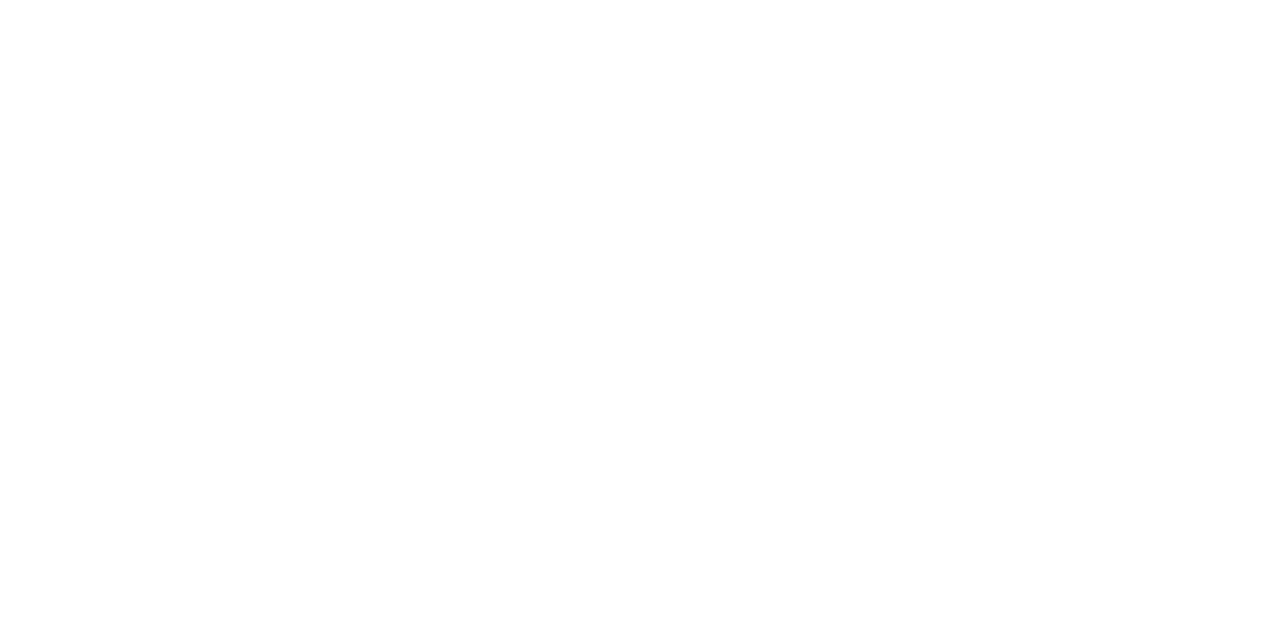

In [26]:
plt.close('all')
fig, ax = rollout_plot_log_scale(steps_pos, error_pos, path_plots, metric = "Position", title = "Rollout Plot: Log Scale")
plt.show()

In [27]:
save_data("rollout_error_position", error_pos)
save_data("rollout_error_velocity", error_vel)